# Calibration using Zhang's procedure

In [1]:
from matplotlib import pyplot as plt
import os
import numpy as np
import cv2 # OpenCV
from calibration import Calibrator

## 1. Calibrate using Zhang procedure, i.e., find the intrinsic parameters K and, for each image, the pair of R, t (extrinsic);

In [3]:
calibrator = Calibrator()

folderpath = './images'
images_path = [os.path.join(folderpath, imagename) for imagename in os.listdir(folderpath) if imagename.endswith(".tiff")]
images_path.sort()
limages = []

for path in images_path:
    image = cv2.imread(path)
    limages.append(image)


calibrator.fit(limages, radial_distortion=False, iterative=False)
print("K:",calibrator.K)
print("Rotation matrices:")
for i,R in enumerate(calibrator.rotations):
    print(f"R{i+1}:{R}")
print("Translation vectors:")
for i,t in enumerate(calibrator.translations):
    print(f"t{i+1}:{t}")

K: [[1.74422010e+03 1.04759684e+00 6.32237799e+02]
 [0.00000000e+00 1.74503682e+03 4.97985025e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
Rotation matrices:
R1:[[ 0.33787874 -0.91248687 -0.23066356]
 [-0.94006349 -0.33916803 -0.03529421]
 [-0.0460282   0.22876356 -0.97239325]]
R2:[[-0.88152475  0.41288342  0.22900085]
 [ 0.4636039   0.84875935  0.25432063]
 [-0.08936184  0.33035562 -0.93961674]]
R3:[[ 0.54291866 -0.6792282  -0.49385057]
 [-0.8111839  -0.57633104 -0.09911212]
 [-0.21730167  0.45441345 -0.86387986]]
R4:[[-0.85853004  0.47109063  0.20248404]
 [ 0.49752103  0.86087629  0.10660594]
 [-0.12409265  0.19226447 -0.97346566]]
R5:[[-0.72269343  0.65160731  0.23048237]
 [ 0.67737341  0.7340212   0.04876612]
 [-0.13740259  0.19136559 -0.97185377]]
R6:[[ 0.14514983 -0.9618107  -0.23205968]
 [-0.92406091 -0.21560716  0.31563426]
 [-0.35361413  0.16862302 -0.92006702]]
R7:[[ 0.43553093 -0.88373416 -0.17125056]
 [-0.87182448 -0.46147888  0.16419291]
 [-0.2241314   0.07778934 

## 2. Choose one of the calibration images and compute the total reprojection error for all the grid points (adding a figure with the reprojected points);
We will perform the procedure on the 8-th image, first with the basic procedure then with the iterative one
### Basic procedure

Text(0.5, 1.0, 'Total reprojection error: 261.8414087724524')

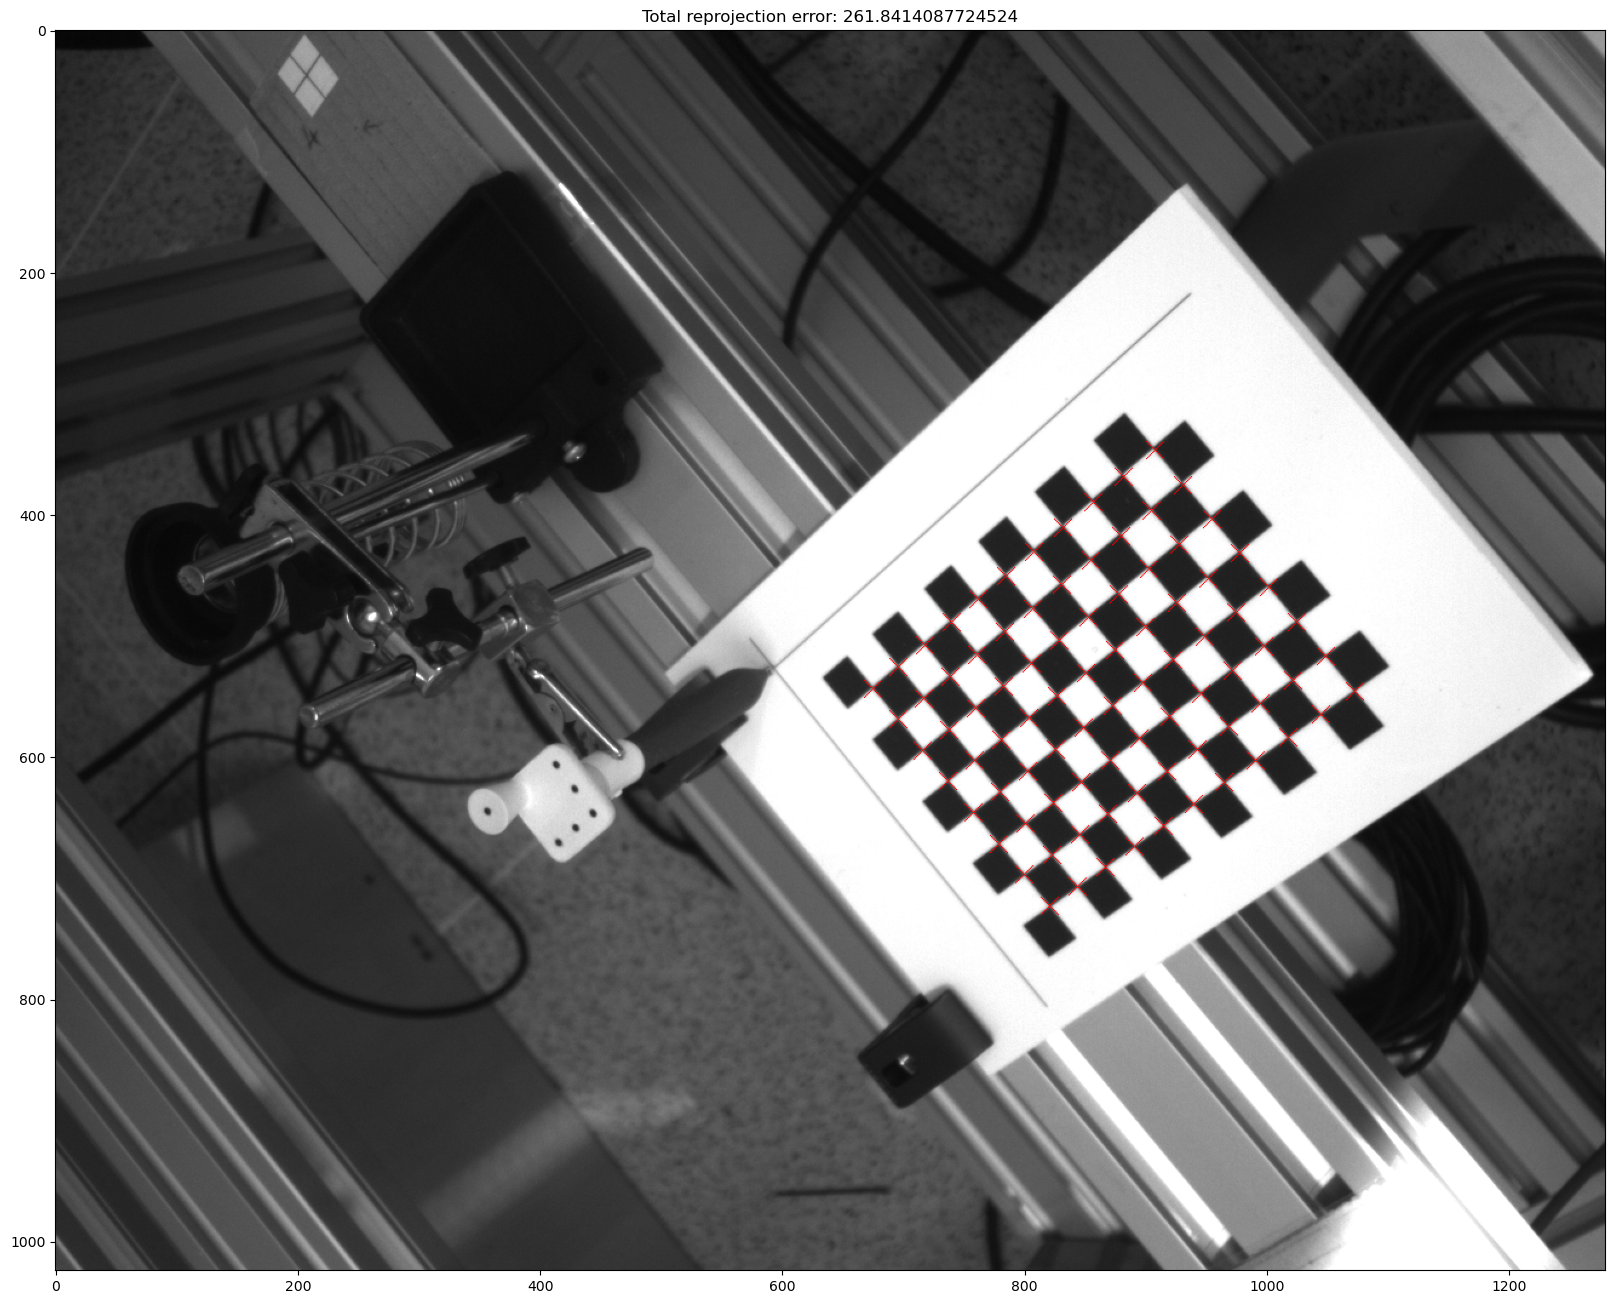

In [25]:
calibrator.fit(limages, radial_distortion=False, iterative=False)
index = 7
R, P, error = calibrator.real_coords, calibrator.projection_matrices[index], calibrator.reprojection_errors[index]
image7 = cv2.imread(images_path[index])
proj_chess = np.transpose(P@R.T)
proj_chess[:,0] = proj_chess[:,0]/proj_chess[:,2]
proj_chess[:,1] = proj_chess[:,1]/proj_chess[:,2]
proj_chess = proj_chess[:,:-1]
copy1 = image7.copy()
for point in proj_chess:
    copy1 = cv2.drawMarker(img=copy1,
                           position=tuple(np.array(point, dtype=np.int32)),
                           color=(255,0,0),
                           markerType=cv2.MARKER_TILTED_CROSS,
                           thickness=1,
                           markerSize=15
                           )
plt.figure(figsize=(20,20))
plt.imshow(copy1)
plt.title(f"Total reprojection error: {error}")

### Iterative refinement

Text(0.5, 1.0, 'Total reprojection error: 2.2047359060795193')

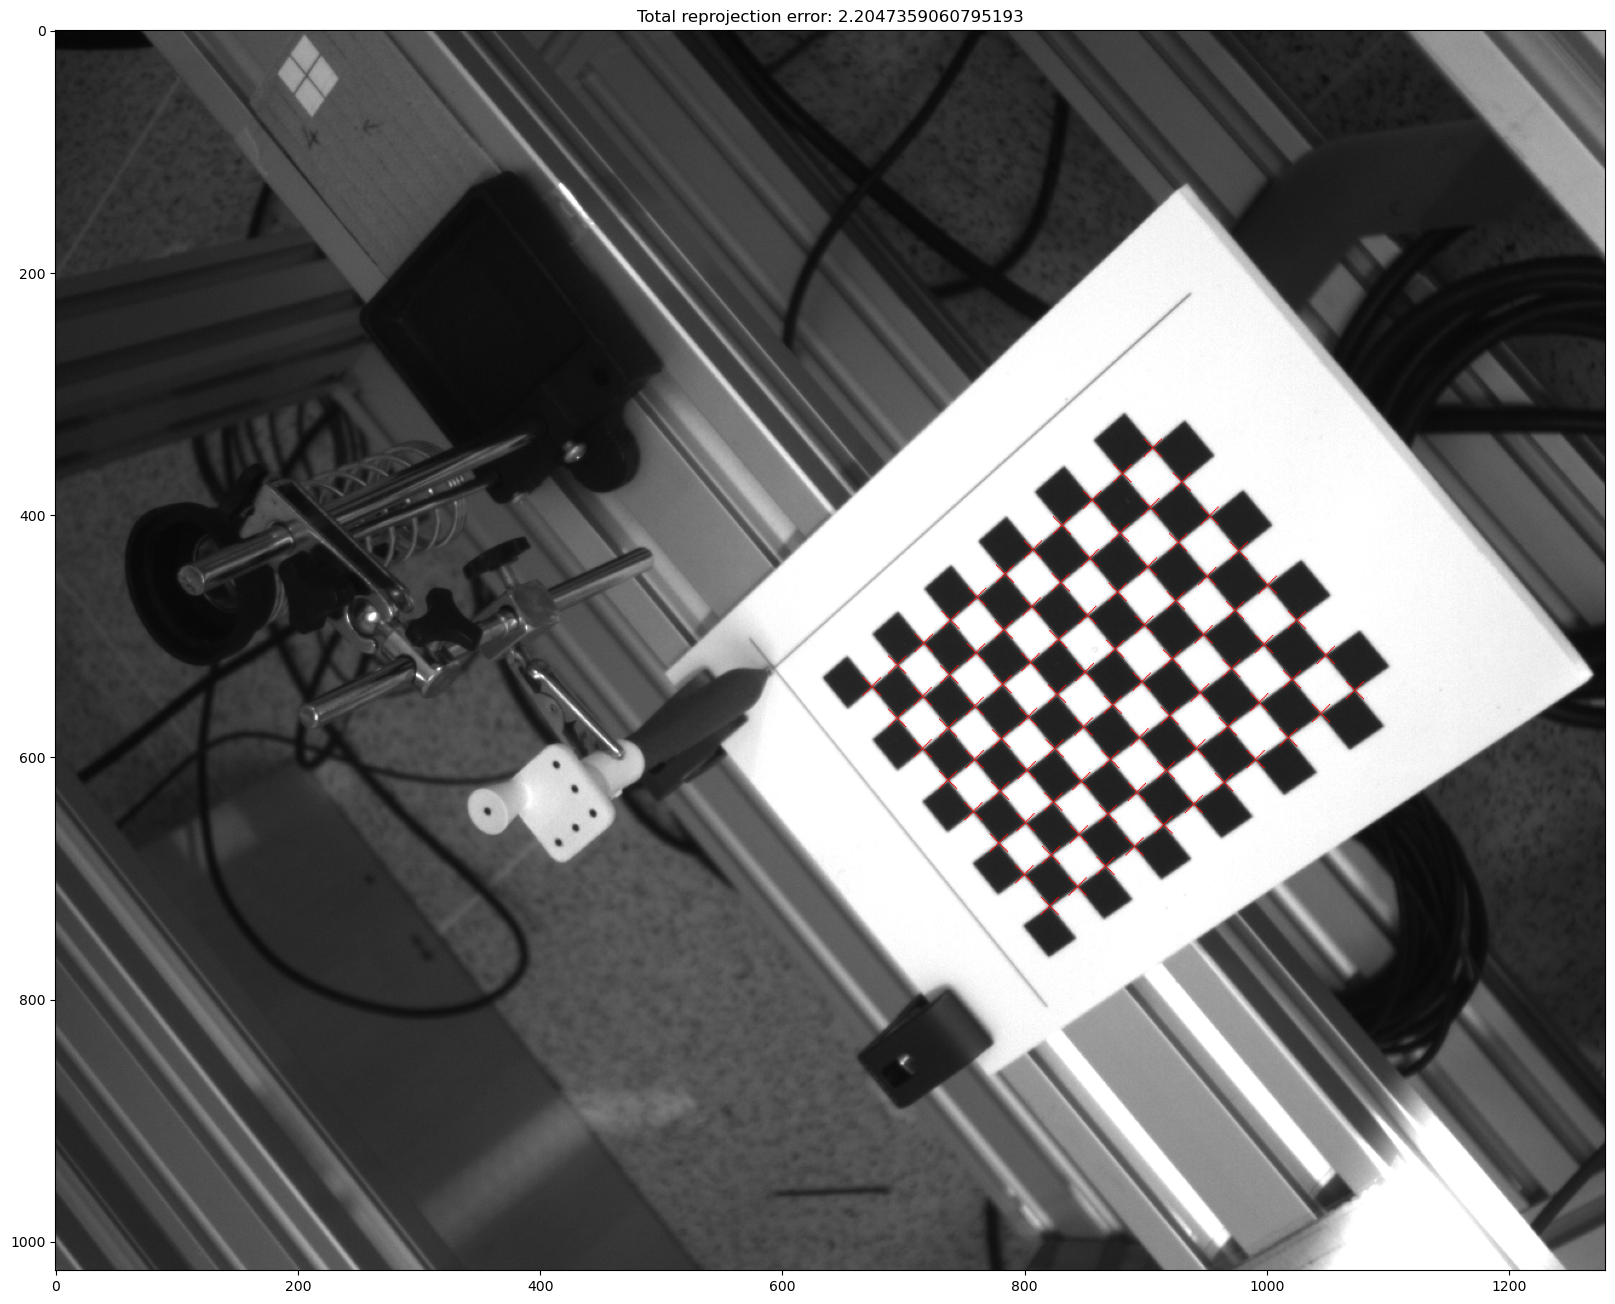

In [26]:
calibrator.fit(limages, radial_distortion=False, iterative=True)
index = 7
R, P, error = calibrator.real_coords, calibrator.projection_matrices[index], calibrator.reprojection_errors[index]
image7 = cv2.imread(images_path[index])
proj_chess = np.transpose(P@R.T)
proj_chess[:,0] = proj_chess[:,0]/proj_chess[:,2]
proj_chess[:,1] = proj_chess[:,1]/proj_chess[:,2]
proj_chess = proj_chess[:,:-1]
copy1 = image7.copy()
for point in proj_chess:
    copy1 = cv2.drawMarker(img=copy1,
                           position=tuple(np.array(point, dtype=np.int32)),
                           color=(255,0,0),
                           markerType=cv2.MARKER_TILTED_CROSS,
                           thickness=1,
                           markerSize=15
                           )
plt.figure(figsize=(20,20))
plt.imshow(copy1)
plt.title(f"Total reprojection error: {error}")

## 3. Superimpose an object (for instance, a cylinder), to the calibration plane, in all the images employed for the calibration;

In [27]:
# Funzione generata con Microsoft Copilot
def create_image_grid(image_list, grid_size):
    rows, cols = grid_size
    if len(image_list) != rows * cols:
        raise ValueError("Il numero di immagini non corrisponde alla dimensione della griglia")

    img_height, img_width = image_list[0].shape[:2]

    grid_image = np.zeros((rows * img_height, cols * img_width, 3), dtype=np.uint8)

    for idx, img in enumerate(image_list):
        row = idx // cols
        col = idx % cols
        grid_image[row * img_height:(row + 1) * img_height, col * img_width:(col + 1) * img_width] = img

    return grid_image

In [28]:
pts = cv2.ellipse2Poly((44,55), (22,22), 0, 0, 360, 1)
pts = pts/1000
et_low = np.empty_like(pts)
et_high = np.empty_like(et_low)
pts_low = np.hstack((pts, np.zeros((pts.shape[0],1)), np.ones((pts.shape[0],1))))
pts_high = np.hstack((pts, np.full((pts.shape[0],1), 0.055), np.ones((pts.shape[0],1))))

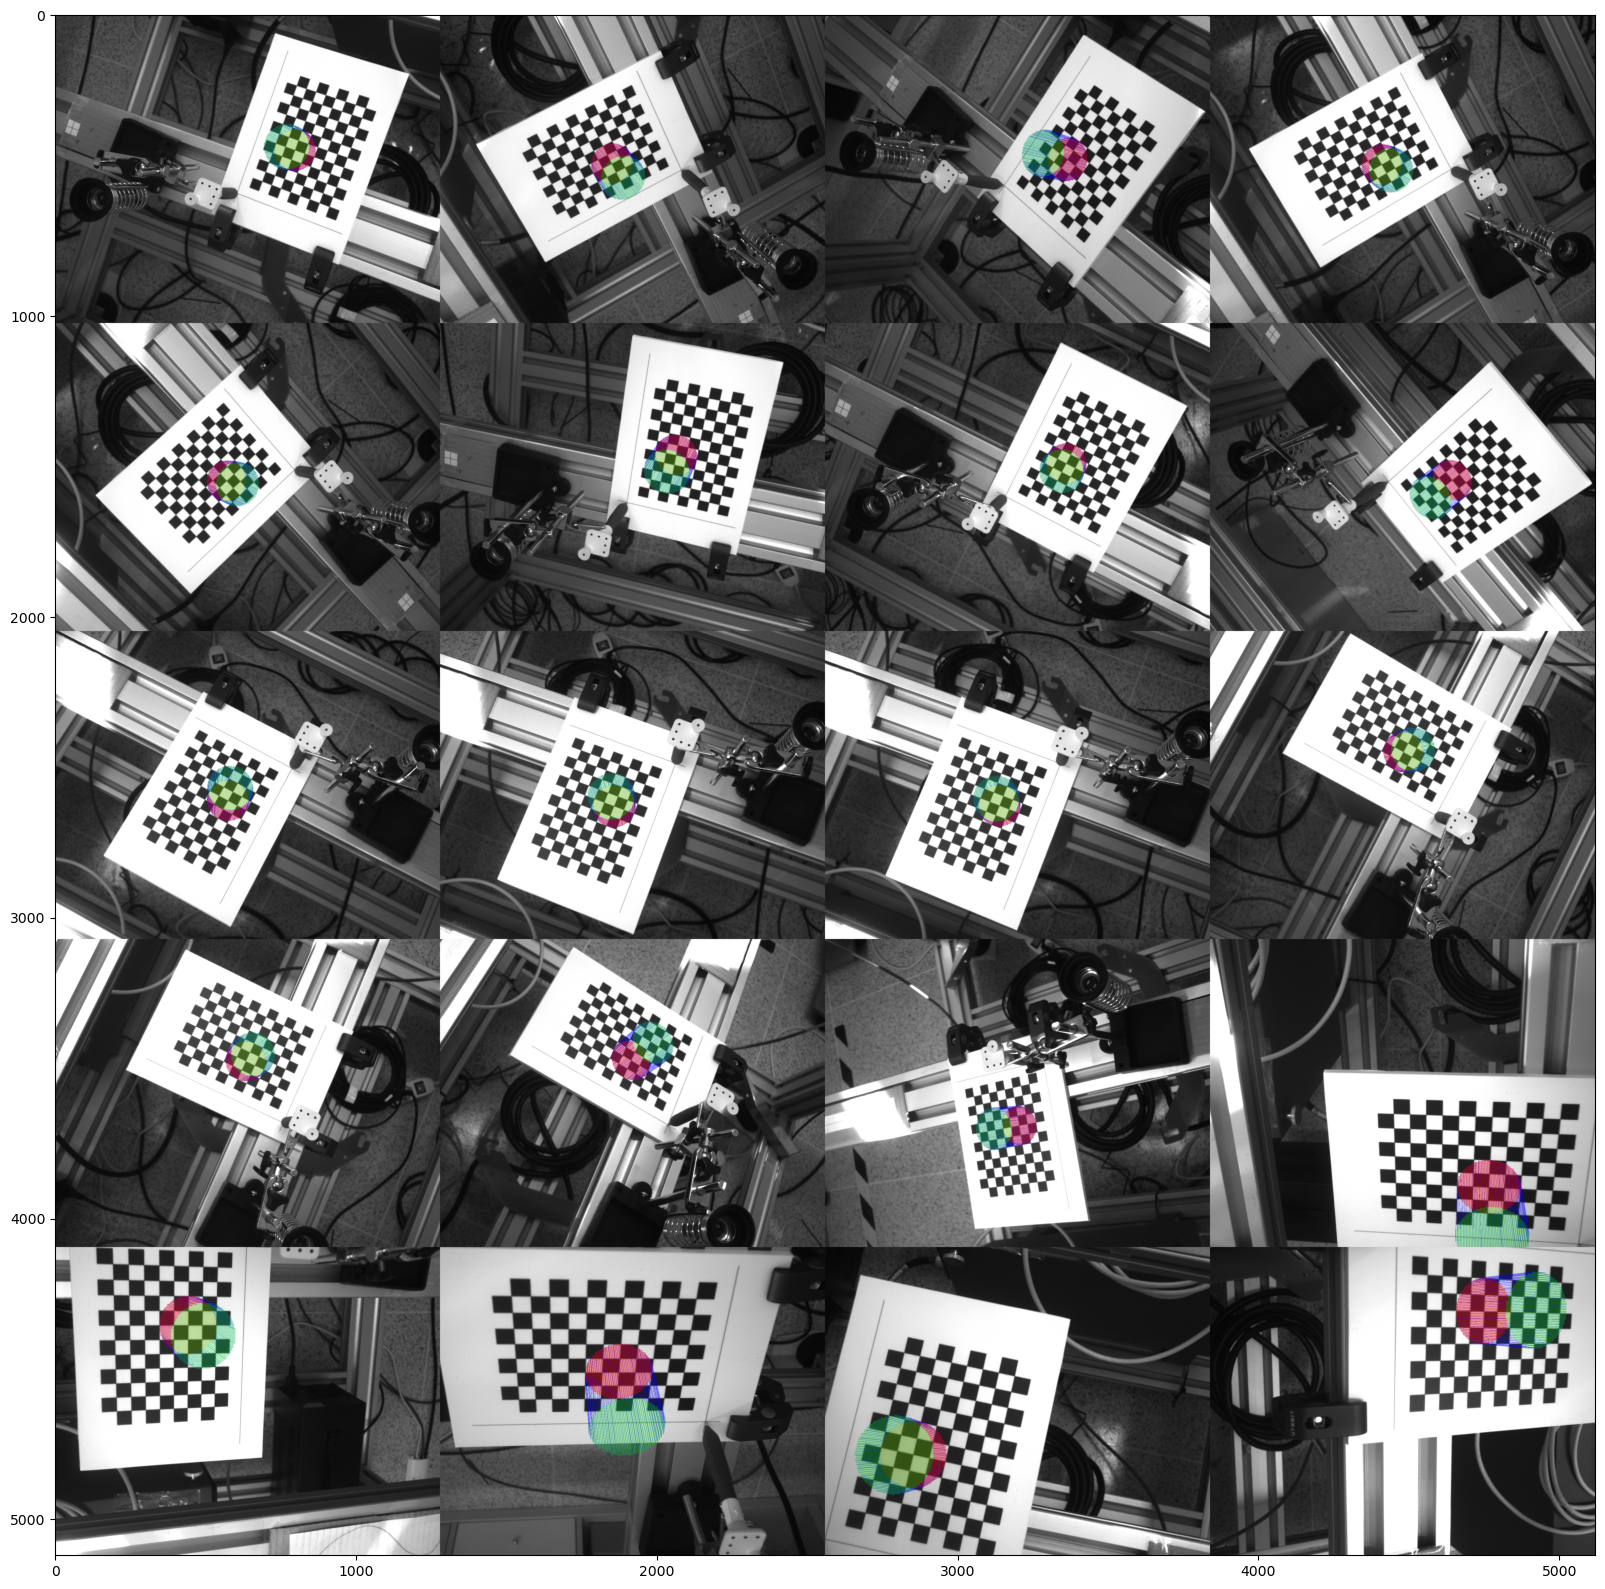

In [29]:
image_list = []
for i,path in enumerate(images_path):
    original = cv2.imread(path)
    P = calibrator.projection_matrices[i]

    proj_low = np.transpose(P @ pts_low.T)
    et_low[:,0] = proj_low[:,0]/proj_low[:,2]
    et_low[:,1] = proj_low[:,1]/proj_low[:,2]

    proj_high = np.transpose(P @ pts_high.T)
    et_high[:,0] = proj_high[:,0]/proj_high[:,2]
    et_high[:,1] = proj_high[:,1]/proj_high[:,2]

    img2 = original.copy()
    img2 = cv2.fillConvexPoly(img2,np.array(et_low, dtype=np.int32),(255,0,0))
    img3 = cv2.fillConvexPoly(img2.copy(),np.array(et_high, dtype=np.int32),(0,255,0))
    img4 = original.copy()
    for i in range(et_low.shape[0]):
        img4 = cv2.line(img4, tuple(np.array(et_low[i], dtype=np.int32)), tuple(np.array(et_high[i], dtype=np.int32)),(0,0,255))
    img2 = cv2.addWeighted(img2, 0.5, original, 0.5, 0)
    img3 = cv2.addWeighted(img2, 0.5, img3, 0.5, 0)
    img4 = cv2.addWeighted(img3, 0.5, img4, 0.5, 0)
    image_list.append(img4)

compound = create_image_grid(image_list, (5,4))
plt.figure(figsize=(20,20))
plt.imshow(compound)